# Solving Fast Oscillations in 1D Axisymmetric Neutrino Gases with `NuGas`

## Huaiyu Duan (UNM)

The `f2e0d1a` model solves the two-flavor fast oscillations in a 1D, axisymmetric neutrino gas without collisions that has the following equation of motion:
$$
    (\partial_t + u\partial_z) \mathbf{P}_u
    = (\mathbf{N} - u\mathbf{F}) \times \mathbf{P}_u,
$$
where $\mathbf{P}_u(t,z)$ is the Bloch vector that represents the flavor content of the neutrinos and antineutrinos of velocity $u$ along the $z$ axis and at the time-space point $(t,z)$, and $\mathbf{N}=\int_{-1}^1 G(u)\mathbf{P}_u\mathrm{d}u$ and $\mathbf{F}=\int_{-1}^1 G(u)\mathbf{P}_u u\mathrm{d}u$ are the flavor density and flux, respectively. This equations ignores the vacuum Hamiltonian and assumes the co-rotating frame in which the matter potential is 0.

## Numerical quadrature

The integration over $u$ can be handled by a numerical quadrature:
$$
\int_{-1}^1 f(u)\mathrm{d}u \approx \sum_{a=0}^{N_u-1} f(u_a) w_a,
$$
where $u_a$ ($a=0,1,\ldots,N_u$) are the mesh points, and $w_a$ are the appropriate weights. The `misc.quadrature` module provides several quadrature rules.

In [1]:
import nugas.misc.quadrature as qd

print(list(qd.RULES.keys()))

['midpoint', 'trapezoid', 'simpson', 'simpson2', 'chebyshev', 'legendre']


In [2]:
help(qd.mesh)

Help on function mesh in module nugas.misc.quadrature:

mesh(a, b, n, rule='midpoint')
    Compute the abscissas x[n] and weights w[n] using n nodes and the specified rule.
    The sum of f(x[i]) * w[i] gives an approximation of integral of f(x) for x from a to b.
    a : lower limit of the integral
    b : upper limit of the integral
    n : number of nodes
    rule : name of the quadrature rule
    
    return : x[n], w[n]



In [3]:
import numpy as np

Nu = 100 # number of angular bins
u, w = qd.mesh(-1, 1, Nu)
np.sum(u**2 * w) # integral of u^2 on [-1, 1]

0.6666000000000001

## A simple example

One creates a neutrino gas model by define a `NuGas` object. To initialize a `NuGas` object, one needs to supply the spatial mesh (on a periodic box), angular mesh and weights, the ELN distribution, and the initial condition. The initial Bloch vectors should be a `NumPy` array of the shape `(Nz, Nu, 3)`, where `Nz` and `Nu` are the numbers of spatial and angular bins, respectively. Here is a simple example.

In [4]:
# ELN distribution
G = lambda v : 0.5 - 0.3*v
g = G(u)

# spatial bins
L = 10 # size of the periodic box
Nz = 200 # number spatial bins
z = np.arange(Nz) * (L/Nz) # spatial mesh

# initial polarization vectors
P_ini = np.empty((3, Nu, Nz), dtype=np.double)
P_ini[0] = 0.5 * np.cos(2*np.pi*z/L) # P_1 at t=0
P_ini[1] = 0.5 * np.sin(2*np.pi*z/L) # P_2
P_ini[2] = np.sqrt(1 - P_ini[0]**2 - P_ini[1]**2)

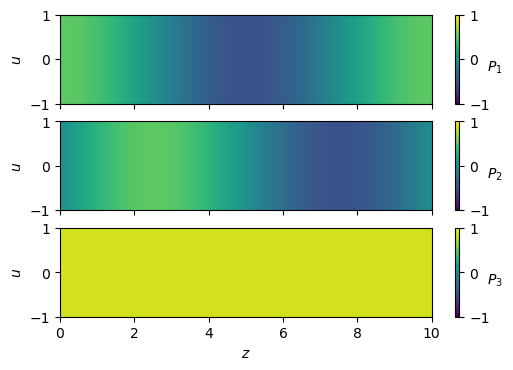

In [5]:
# plot the initial Bloch vectors

import matplotlib.pyplot as plt
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

fig = plt.figure(dpi=100)
ax1, ax2, ax3 = fig.subplots(3, sharex=True)
im1 = ax1.imshow(P_ini[0], extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im1, ax=ax1).set_label('$P_1$', rotation='horizontal')
ax1.set_ylabel('$u$')
im2 = ax2.imshow(P_ini[1], extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im2, ax=ax2).set_label('$P_2$', rotation='horizontal')
ax2.set_ylabel('$u$')
im3 = ax3.imshow(P_ini[2], extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im3, ax=ax3).set_label('$P_3$', rotation='horizontal')
ax3.set_ylabel('$u$')
ax3.set_xlabel('$z$')
plt.show()

In [6]:
from nugas.f2e0d1a import NuGas

# initialize the model
gas1 = NuGas(P=P_ini.T, z=z, u=u, weights=w, g=g)

# evolve the gas to t = 5
t, P = gas1.evolve(5)

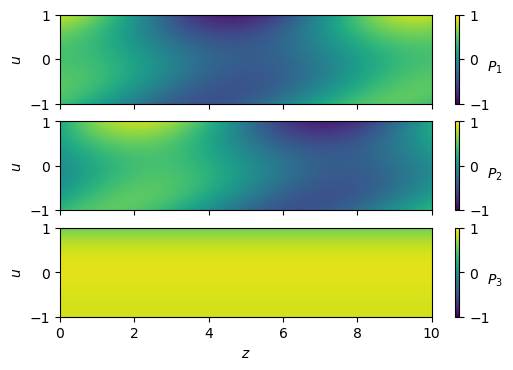

In [7]:
# plot the current Bloch vectors

fig = plt.figure(dpi=100)
ax1, ax2, ax3 = fig.subplots(3, sharex=True)
im1 = ax1.imshow(P[:,:,0].T, extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im1, ax=ax1).set_label('$P_1$', rotation='horizontal')
ax1.set_ylabel('$u$')
im2 = ax2.imshow(P[:,:,1].T, extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im2, ax=ax2).set_label('$P_2$', rotation='horizontal')
ax2.set_ylabel('$u$')
im3 = ax3.imshow(P[:,:,2].T, extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im3, ax=ax3).set_label('$P_3$', rotation='horizontal')
ax3.set_ylabel('$u$')
ax3.set_xlabel('$z$')
plt.show()

## Flavor history

For a large calculation, one may want to save the intermediate snapshots of the flavor evolution. Here are the relevant parameters to initialize the `NuGas` object with this option which requires [`netCDF4`](https://unidata.github.io/netcdf4-python/).
- `data_file` is the name of the NetCDF file that stores the flavor history. It can be any string. 
- `history` can be one of the following: `'new'` means to start a new data file (and overwrite any existing file of the same name), `'continue'` means to load the data file and continue the calculation, and `'readonly'` means to load the data file to read the flavor history. Default is `'readonly'`. A readonly gas model cannot be evolved.

`NuGas.evolve()` have the following parameters:  
- `t` can be a number or array of time(s) to reach. It must be larger than the last time the system evolved to (or the initial time if it has not been evolved.)
- `progress` can be `True` or `False` indicating whether to report what time the model is at. Default is `False`.
- `flush_int` is an integer. The data will be flushed to disk every this number of snapshots. A negative number or 0 means no intermediate flush.

In [8]:
datafile = 'test.nc' # name of the data file

# initialize the model with data files
gas1 = NuGas(P=P_ini.T, z=z, u=u, weights=w, g=g, data_file=datafile, history='new')

# evolve the gas 
tt = np.linspace(0, 5, 6) # time points where snapshots to be saved
t, P = gas1.evolve(tt[1:]) # skip the initial time!!!

In [9]:
# load the history into another model to read it
gas2 = NuGas(data_file=datafile)
print(gas2.t.shape) # see what snapshots have been saved
print(gas2.P.shape) # gas2.P should have shape of (Nz, Nu, len(gas2.t))

(6,)
(6, 200, 100, 3)


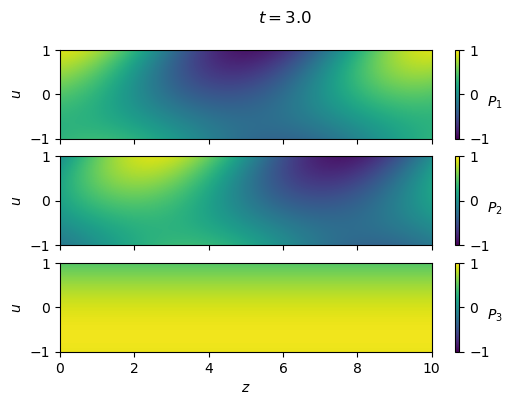

In [10]:
# choose a snapshot
ti = 3
t = gas2.t[ti]
P = gas2.P[ti]

# plot the current Bloch vectors of the snapshot
fig = plt.figure(dpi=100)
ax1, ax2, ax3 = fig.subplots(3, sharex=True)
im1 = ax1.imshow(P[:,:,0].T, extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im1, ax=ax1).set_label('$P_1$', rotation='horizontal')
ax1.set_ylabel('$u$')
im2 = ax2.imshow(P[:,:,1].T, extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im2, ax=ax2).set_label('$P_2$', rotation='horizontal')
ax2.set_ylabel('$u$')
im3 = ax3.imshow(P[:,:,2].T, extent=[0, L, -1, 1], origin="lower", aspect="auto", norm=norm)
fig.colorbar(im3, ax=ax3).set_label('$P_3$', rotation='horizontal')
ax3.set_ylabel('$u$')
ax3.set_xlabel('$z$')
plt.suptitle(f'$t={t}$')
plt.show()

## Other choices

By default, `NuGas` uses 5-point, finite differencing to approximate the spatial derivative and the `RK45` ODE solver from SciPy to solve the flavor equation of motion. One can change the default choices by specifying the following parameters:
- `pdz` can be `'fd3'`, `'fd5'`, `'fd7'`, or `'fd9'` which stand for the central finite differencing with 3, 5, 7, and 9 points, respectively, or `'fft'` which uses FFT to compute the spatial derivative.
- `eom_c` is either `True` or `False` indicating whether to use the C++ version of the equation of motion. It must be `False` if `pdz` is `'fft'`. The default value is `False`. 
- `integrator` is one of the following SciPy integrators:

In [11]:
from nugas.misc.misc import INTEGRATORS, OLD_INTEGRATORS
print(list(INTEGRATORS.keys()) + OLD_INTEGRATORS) # names of the integrators

['RK23', 'RK45', 'DOP853', 'Radau', 'BDF', 'LSODA', 'vode', 'zvode', 'lsoda', 'dopri5', 'dopr853']


A special case is when `integrator` is set as `lax42`. In this case, a C++ extension that implements the Lax42 algorithm is used [[arXiv:2110.02286]](https://arxiv.org/abs/2110.02286). Both `pdz` and `eom_c` will not be used when `lax42` is the `integrator`.

## Acknowledgments

This material is based upon work supported by the U.S. Department of Energy, Office of Science, Office of Nuclear Physics under Award Number DE-SC-0017803.